In [5]:
import pickle as pkl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

W0830 12:22:42.542988 13972 deprecation.py:323] From C:\Users\hiro\Anaconda3\envs\GAN_introduction\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\base.py:252: _internal_retry.<locals>.wrap.<locals>.wrapped_fn (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please use urllib or similar directly.


Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data\train-images-idx3-ubyte.gz


Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data\train-labels-idx1-ubyte.gz


Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Successfully downloaded

 t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


### Create placeholder 

In [7]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z


### Create generator

In [8]:
def generator(z, out_dim, n_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope('generator', reuse=reuse):
        h1 = tf.layers.dense(z, n_units, activation=None)
        h1 = tf.maximum(alpha * h1, h1)  # Leaky ReLU
        
        logits = tf.layers.dense(h1, out_dim, activation=None)
        out = tf.tanh(logits)
        
        return out
    

### Create discriminator 

In [9]:
def discriminator(x, n_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope('discriminator', reuse=reuse):
        h1 = tf.layers.dense(x, n_units, activation=None)
        h1 = tf.maximum(alpha * h1, h1)
        
        logits = tf.layers.dense(h1, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits


### Initialize hyper parameters

In [10]:
input_size = 784
z_size = 100
g_hidden_size = 128
d_hidden_size = 128
alpha = 0.01
smooth = 0.1

### Define the graph of GAN model

In [11]:
tf.reset_default_graph()
input_real, input_z = model_inputs(input_size, z_size)

g_model = generator(input_z, input_size, n_units=g_hidden_size, alpha=alpha)

d_model_real, d_logits_real = discriminator(input_real, n_units=d_hidden_size, alpha=alpha)
d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, n_units=d_hidden_size, alpha=alpha)


W0829 18:14:15.053173  3320 deprecation.py:323] From <ipython-input-8-9c158cb902f0>:3: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.


W0829 18:14:15.062148  3320 deprecation.py:506] From C:\Users\hiro\Anaconda3\envs\tf16cpu\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### define loss functions

In [12]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                     labels=tf.ones_like(d_logits_real) * (1 - smooth)))

d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                     labels=tf.zeros_like(d_logits_real)))

d_loss = d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                labels=tf.ones_like(d_logits_fake)))


W0829 18:14:15.816159  3320 deprecation.py:323] From C:\Users\hiro\Anaconda3\envs\tf16cpu\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Define a learning rate

In [13]:
learning_rate = 0.002

t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

g_train_optimize = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
d_train_optimize = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

### Check the batch data

In [14]:
batch_size = 100
batch = mnist.train.next_batch(batch_size)

In [15]:
batch

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([2, 9, 6, 1, 9, 5, 4, 4, 8, 4, 1, 1, 2, 5, 7, 1, 8, 5, 3, 9, 2, 1,
        6, 2, 6, 8, 8, 3, 6, 4, 4, 1, 9, 1, 0, 6, 3, 2, 7, 3, 1, 1, 7, 8,
        3, 2, 7, 0, 3, 1, 0, 6, 0, 4, 6, 9, 7, 2, 6, 3, 1, 8, 0, 5, 3, 8,
        3, 8, 0, 3, 7, 7, 6, 1, 2, 5, 8, 6, 4, 6, 6, 1, 1, 2, 0, 3, 7, 1,
        0, 8, 0, 6, 2, 1, 3, 7, 4, 6, 8, 8], dtype=uint8))

In [16]:
batch[0][0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [17]:
batch[1][0]

2

### Implement training

In [18]:
epochs = 100
samples = []
losses = []
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for i in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images * 2 - 1
            
            # Generator
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            _ = sess.run(d_train_optimize, feed_dict={input_real: batch_images, input_z: batch_z})
            _ = sess.run(g_train_optimize, feed_dict={input_z: batch_z})
            
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
        train_loss_g = g_loss.eval({input_z: batch_z})
        
        print('エポック数 {}/{}'.format(e + 1, epochs),
              'D ロス: {:.4f}'.format(train_loss_d),
              'G ロス: {:.4f}'.format(train_loss_g))
        
        losses.append((train_loss_d, train_loss_g))
        
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        gen_samples = sess.run(generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),
                               feed_dict={input_z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')
        
with open('training_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)
    

エポック数 1/100 D ロス: 0.4033 G ロス: 3.0083


エポック数 2/100 D ロス: 0.3577 G ロス: 4.7408


エポック数 3/100 D ロス: 0.3926 G ロス: 3.2365


エポック数 4/100 D ロス: 1.2598 G ロス: 1.5907


エポック数 5/100 D ロス: 1.3184 G ロス: 3.7815


エポック数 6/100 D ロス: 2.2368 G ロス: 3.1297


エポック数 7/100 D ロス: 1.4158 G ロス: 1.3645


エポック数 8/100 D ロス: 2.7509 G ロス: 4.1542


エポック数 9/100 D ロス: 1.3432 G ロス: 2.6620


エポック数 10/100 D ロス: 1.2770 G ロス: 0.9300


エポック数 11/100 D ロス: 1.2331 G ロス: 1.1596


エポック数 12/100 D ロス: 1.0737 G ロス: 3.2055


エポック数 13/100 D ロス: 1.2979 G ロス: 1.6774


エポック数 14/100 D ロス: 1.8289 G ロス: 2.1343


エポック数 15/100 D ロス: 1.1896 G ロス: 1.4460


エポック数 16/100 D ロス: 2.6987 G ロス: 0.5047


エポック数 17/100 D ロス: 3.2004 G ロス: 0.4468


エポック数 18/100 D ロス: 1.0507 G ロス: 1.4245


エポック数 19/100 D ロス: 1.6549 G ロス: 0.7531


エポック数 20/100 D ロス: 1.5186 G ロス: 1.0924


エポック数 21/100 D ロス: 1.9497 G ロス: 1.2058


エポック数 22/100 D ロス: 2.0781 G ロス: 1.4225


エポック数 23/100 D ロス: 1.5502 G ロス: 1.2940


エポック数 24/100 D ロス: 2.5888 G ロス: 1.4900


エポック数 25/100 D ロス: 0.8790 G ロス: 1.3454


エポック数 26/100 D ロス: 1.2612 G ロス: 0.9770


エポック数 27/100 D ロス: 2.3167 G ロス: 1.9349


エポック数 28/100 D ロス: 0.8995 G ロス: 1.5143


エポック数 29/100 D ロス: 1.4103 G ロス: 0.9226


エポック数 30/100 D ロス: 2.2479 G ロス: 1.2559


エポック数 31/100 D ロス: 2.6216 G ロス: 2.1431


エポック数 32/100 D ロス: 2.2573 G ロス: 0.9999


エポック数 33/100 D ロス: 1.9817 G ロス: 0.6889


エポック数 34/100 D ロス: 2.0592 G ロス: 1.0533


エポック数 35/100 D ロス: 3.1805 G ロス: 0.7713


エポック数 36/100 D ロス: 1.5888 G ロス: 1.1199


エポック数 37/100 D ロス: 1.4129 G ロス: 1.8987


エポック数 38/100 D ロス: 1.9883 G ロス: 0.9993


エポック数 39/100 D ロス: 1.8458 G ロス: 1.1034


エポック数 40/100 D ロス: 1.3668 G ロス: 1.3913


エポック数 41/100 D ロス: 1.5726 G ロス: 1.5314


エポック数 42/100 D ロス: 1.3247 G ロス: 1.3460


エポック数 43/100 D ロス: 1.8417 G ロス: 1.0556


エポック数 44/100 D ロス: 1.6358 G ロス: 1.3535


エポック数 45/100 D ロス: 0.9894 G ロス: 2.2388


エポック数 46/100 D ロス: 0.9960 G ロス: 1.7309


エポック数 47/100 D ロス: 0.7991 G ロス: 3.9797


エポック数 48/100 D ロス: 1.0471 G ロス: 1.7511


エポック数 49/100 D ロス: 0.7283 G ロス: 2.6736


エポック数 50/100 D ロス: 0.8180 G ロス: 1.8773


エポック数 51/100 D ロス: 0.7481 G ロス: 2.4600


エポック数 52/100 D ロス: 0.7491 G ロス: 3.0182


エポック数 53/100 D ロス: 0.6793 G ロス: 3.5497


エポック数 54/100 D ロス: 0.7068 G ロス: 3.0343


エポック数 55/100 D ロス: 0.7713 G ロス: 2.6238


エポック数 56/100 D ロス: 0.7733 G ロス: 1.8201


エポック数 57/100 D ロス: 0.9253 G ロス: 2.9081


エポック数 58/100 D ロス: 0.8828 G ロス: 2.2836


エポック数 59/100 D ロス: 0.6708 G ロス: 3.1116


エポック数 60/100 D ロス: 0.8268 G ロス: 2.1787


エポック数 61/100 D ロス: 0.8273 G ロス: 2.2442


エポック数 62/100 D ロス: 0.7474 G ロス: 3.1032


エポック数 63/100 D ロス: 1.1216 G ロス: 1.8376


エポック数 64/100 D ロス: 0.7650 G ロス: 3.0902


エポック数 65/100 D ロス: 0.7539 G ロス: 2.3985


エポック数 66/100 D ロス: 1.0088 G ロス: 2.4675


エポック数 67/100 D ロス: 0.8152 G ロス: 2.3223


エポック数 68/100 D ロス: 0.9138 G ロス: 2.1430


エポック数 69/100 D ロス: 0.8365 G ロス: 2.6282


エポック数 70/100 D ロス: 0.8515 G ロス: 2.0162


エポック数 71/100 D ロス: 0.7478 G ロス: 2.1535


エポック数 72/100 D ロス: 1.0906 G ロス: 1.8090


エポック数 73/100 D ロス: 0.7340 G ロス: 2.8024


エポック数 74/100 D ロス: 0.9206 G ロス: 2.1712


エポック数 75/100 D ロス: 0.7671 G ロス: 2.3007


エポック数 76/100 D ロス: 0.8828 G ロス: 2.2097


エポック数 77/100 D ロス: 0.9562 G ロス: 1.7655


エポック数 78/100 D ロス: 0.7436 G ロス: 2.1086


エポック数 79/100 D ロス: 0.6825 G ロス: 2.5848


エポック数 80/100 D ロス: 0.8462 G ロス: 2.5663


エポック数 81/100 D ロス: 0.8618 G ロス: 2.1272


エポック数 82/100 D ロス: 0.8996 G ロス: 2.0213


エポック数 83/100 D ロス: 1.1577 G ロス: 1.8326


エポック数 84/100 D ロス: 0.8487 G ロス: 2.0210


エポック数 85/100 D ロス: 0.8928 G ロス: 2.4524


エポック数 86/100 D ロス: 0.8889 G ロス: 1.9888


エポック数 87/100 D ロス: 0.7963 G ロス: 2.3788


エポック数 88/100 D ロス: 0.8882 G ロス: 2.0652


エポック数 89/100 D ロス: 0.7412 G ロス: 3.4276


エポック数 90/100 D ロス: 0.8320 G ロス: 2.4453


エポック数 91/100 D ロス: 0.7572 G ロス: 3.1291


エポック数 92/100 D ロス: 0.9119 G ロス: 2.3539


エポック数 93/100 D ロス: 0.9580 G ロス: 1.8219


エポック数 94/100 D ロス: 0.8574 G ロス: 1.8640


エポック数 95/100 D ロス: 0.8615 G ロス: 2.5517


エポック数 96/100 D ロス: 1.0274 G ロス: 1.9784


エポック数 97/100 D ロス: 0.9851 G ロス: 1.5099


エポック数 98/100 D ロス: 0.9239 G ロス: 1.8305


エポック数 99/100 D ロス: 0.9565 G ロス: 2.1845


エポック数 100/100 D ロス: 0.8886 G ロス: 2.1338


### Show the graph

W0829 18:30:24.413103  3320 font_manager.py:1282] findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


W0829 18:30:24.432047  3320 font_manager.py:1282] findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


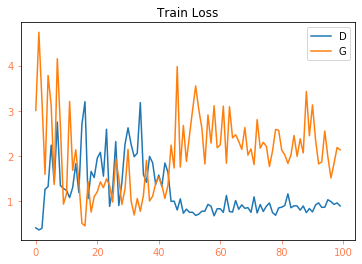

In [19]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='D')
plt.plot(losses.T[1], label='G')
plt.title('Train Loss')
plt.legend()

### Convert it to images

In [20]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7, 7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        
    return fig, axes

In [21]:
with open('training_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

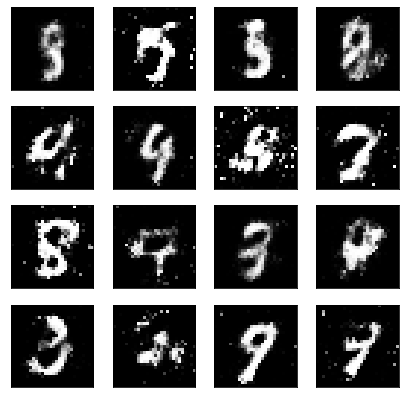

In [22]:
_ = view_samples(-1, samples)

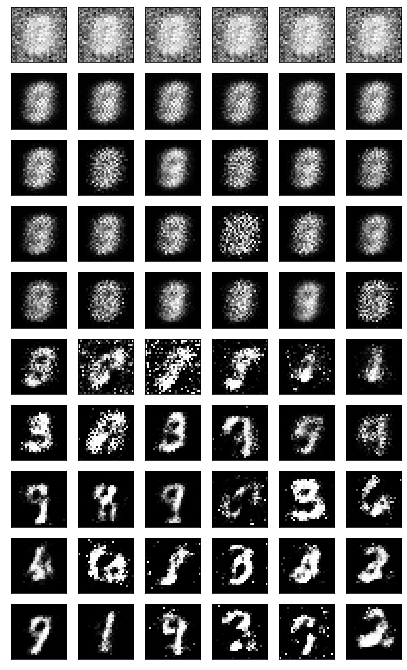

In [23]:
rows, cols = 10, 6
fig, axes = plt.subplots(figsize=(7, 12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        

### Generate new images from checkpoint file (new image generation)

In [24]:
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    

W0829 18:30:32.684978  3320 deprecation.py:323] From C:\Users\hiro\Anaconda3\envs\tf16cpu\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
